In [54]:
library('tidyverse')
library('ggplot2')
library('repr')
library("rvest")

options(repr.plot.widht=4, repr.plot.height=3, repr.plot.res = 300)

In [55]:
world.map <- function(data, title = "", theme = theme_void(), func = function(x)x ) {
    require(maps)

    world_map <- map_data("world")
    map.data <- left_join(world_map, data, by="region")


    plot <- ggplot(map.data, aes(x = long, y = lat, group = group)) + 
        geom_polygon(aes(fill = func(x) ), color = "white", size=0) + 
        scale_fill_distiller(palette = "Blues", na.value = "grey") + theme_void() + theme + 
        ggtitle(title)

    return(plot)
}

In [56]:
## Lee estadísticas del día
webpage <- read_html("https://www.worldometers.info/coronavirus/")
table <- html_nodes(webpage, "table")
raw_data <- html_table(table[[1]], trim=TRUE, fill=TRUE, dec=".")

In [57]:
data <- raw_data %>%
    rename_at(vars(contains("Cases/1M pop")), function(x){"Cases.1M"}) %>%
    rename_at(vars(contains("/1M pop")), function(x){str_replace(x, "/1M pop", ".1M")}) %>%
    rename(
        Country = "Country,Other",
        Critical = "Serious,Critical"
    ) %>%
    mutate(Continent = replace(Continent, Continent == "Australia/Oceania", "Oceania"),
           Country = replace(Country, Country == "DRC", "Democratic Republic of the Congo"),
           Country = replace(Country, Country == "CAR", "Central African Republic"),
           Country = replace(Country, Country == "Congo", "Republic of Congo"),
           Country = replace(Country, Country == "UAE", "United Arab Emirates"),
           Country = replace(Country, Country == "S. Korea", "South Korea"),
           Country = replace(Country, Country == "Czechia", "Czech Republic"),
           Country = replace(Country, Country == "North Macedonia", "Macedonia"),
           TotalCases = as.numeric(gsub(',','',TotalCases)),
           TotalTests = as.numeric(gsub(',','',TotalTests)),
           TotalDeaths = as.numeric(gsub(',','',TotalDeaths)),
           NewDeaths = as.numeric(gsub(',','',NewDeaths)),
           NewCases = as.numeric(gsub(',','',NewCases)),
           TotalRecovered = as.numeric(gsub(',','',TotalRecovered)),
           ActiveCases = as.numeric(gsub(',','',ActiveCases)),
           Critical = as.numeric(gsub(',','',Critical)),
           Cases.1M = as.numeric(gsub(',','',Cases.1M)),
           Tests.1M = as.numeric(gsub(',','',Tests.1M)),
           Deaths.1M = as.numeric(gsub(',','',Deaths.1M)),
           Continent = as.factor(Continent),
           positive.rate = TotalCases/TotalTests,
           fatality.rate = TotalDeaths/TotalCases,
           growth.rate = NewCases/(TotalCases - NewCases),
           critical.rate = Critical/ActiveCases
    ) %>%
    filter(Country != Continent & Country != "World" & Country != "Total:" & Continent != "")

Warning message:
“NAs introducidos por coerción”


In [58]:
theme1 <- theme(legend.position = 'none', 
               plot.title = element_text(color="grey", size=9)
              )

theme2 <- theme(legend.position = 'none', 
               plot.title = element_text(color="grey", size=9),
               axis.title.x = element_text(color="grey", size=7),
               axis.title.y = element_text(color="grey", size=7),
               axis.text.y = element_text(color="grey", size=6),
               axis.text.x = element_text(color="grey", size=6),
              )

# Análisis de Covid-19 

Los datos para este análisis se extrajeron desde [worldometers](https://www.worldometers.info/coronavirus/)

## Distribución de casos 

Los siguiente gráfico muestra la distribución a nivel mundial de casos activos y la cantidad de casos en relación a la población

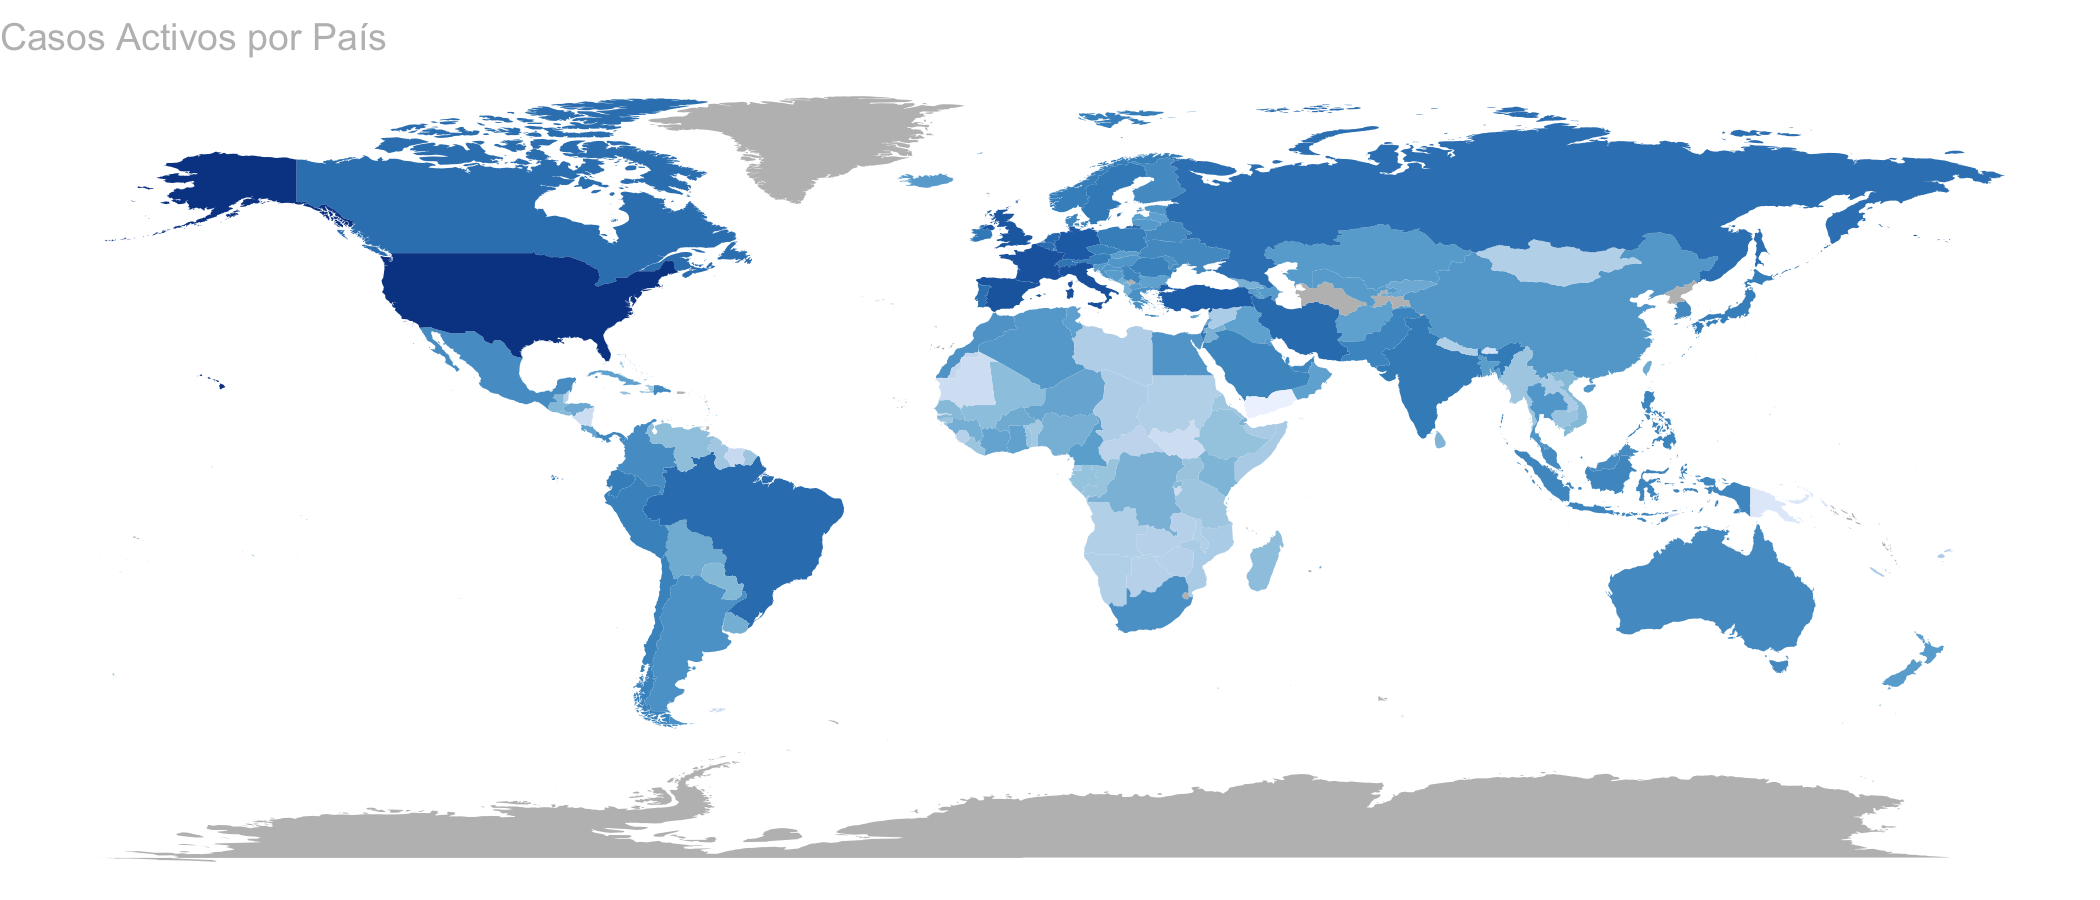

Selecting by Cases.1M



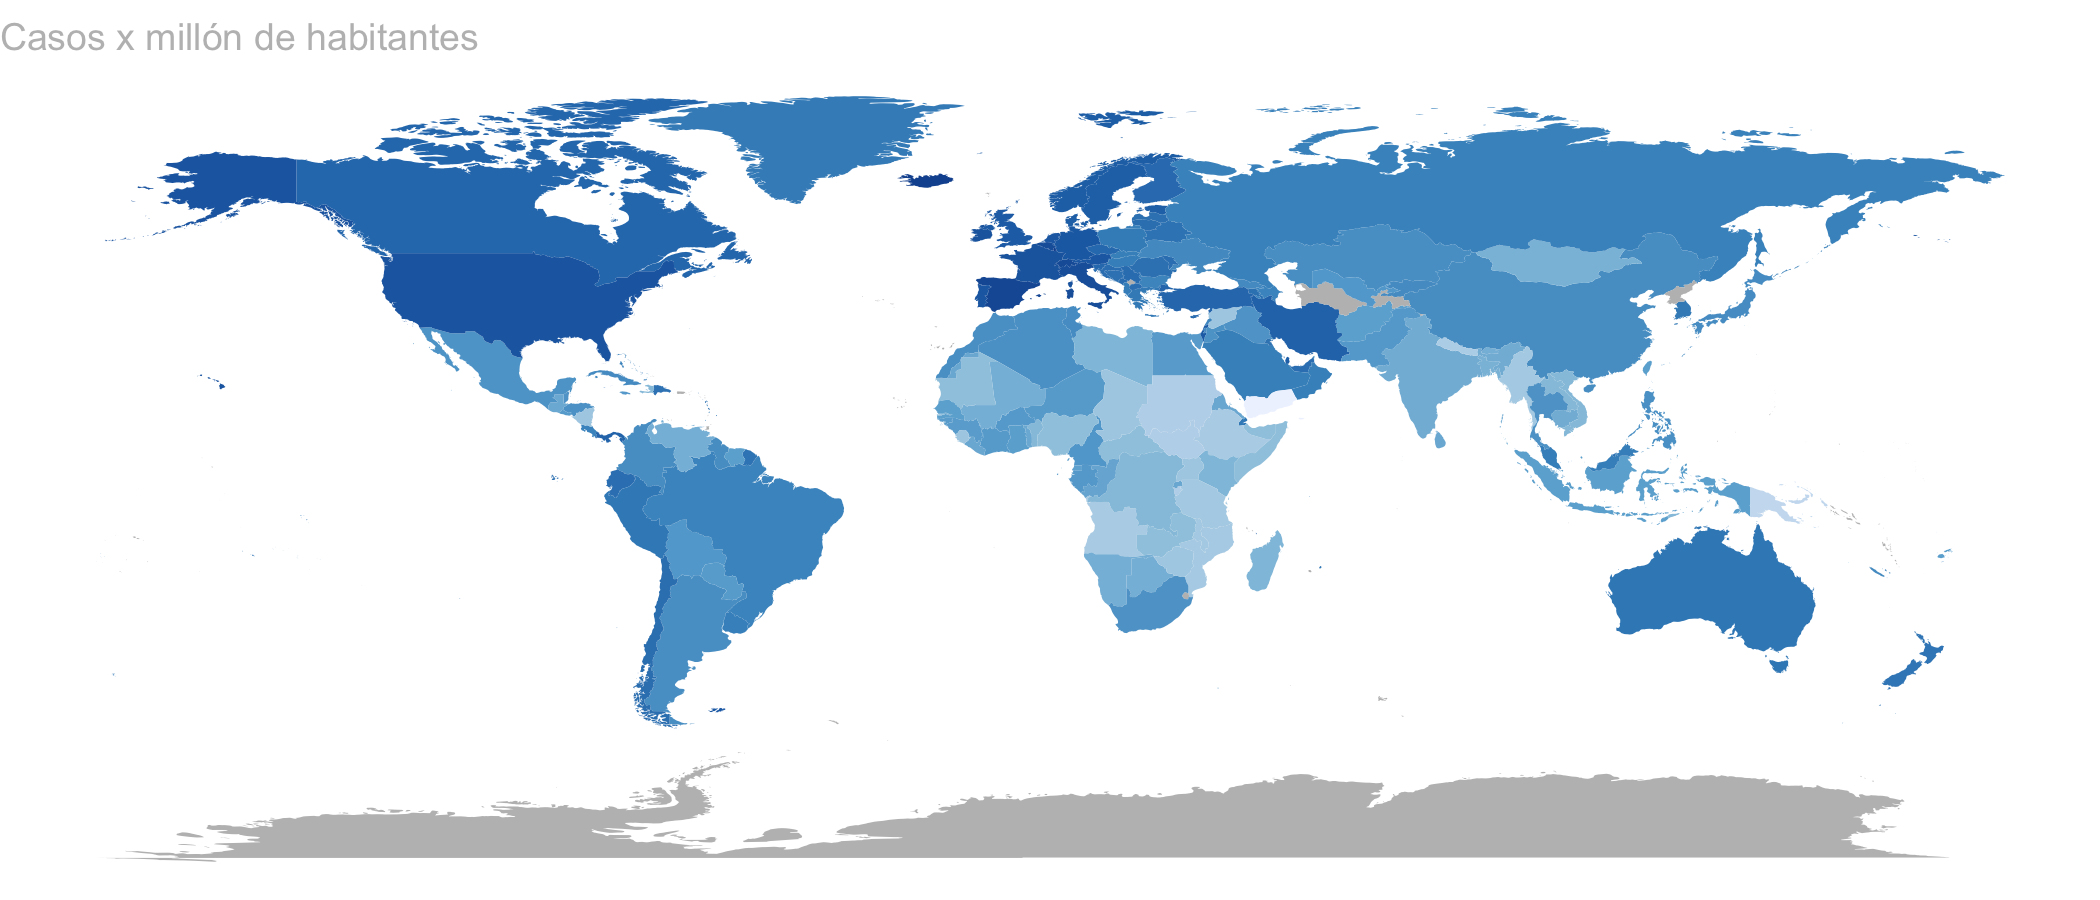

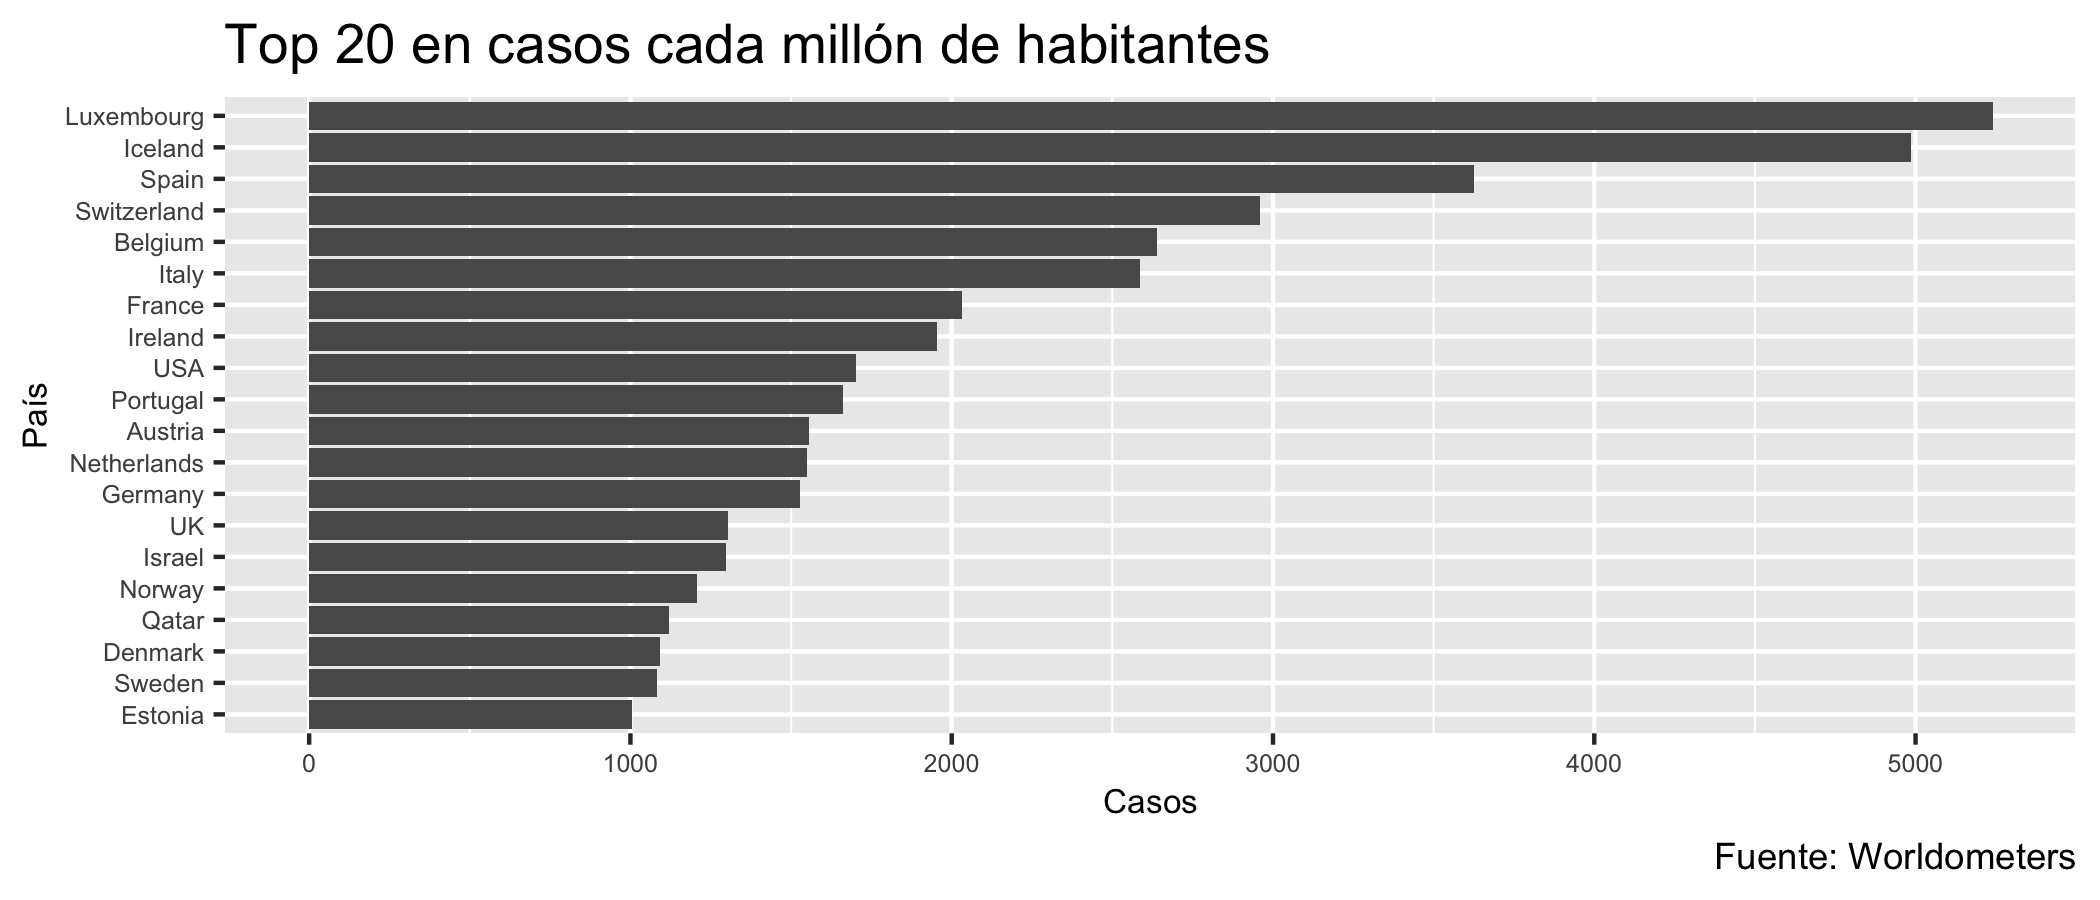

In [59]:
data %>%
    select(region = Country, x=ActiveCases) %>%
    world.map(theme = theme1, title = "Casos Activos por País", func = function(x){-log10(x)})

data %>%
    select(region = Country, x=Cases.1M) %>%
    world.map(theme = theme1, title = "Casos x millón de habitantes", func = function(x){-log10(x)})

data %>%
    filter(TotalCases >= 1000) %>%
    arrange(desc(Cases.1M)) %>%
    select(Country, Cases.1M) %>%
    top_n(20) %>%
    ggplot(aes(x=reorder(Country,Cases.1M),y=Cases.1M)) + 
    geom_bar(stat = 'identity') +
    ylab("Casos") +
    xlab("País") +
    labs(
        title = "Top 20 en casos cada millón de habitantes",
        caption="Fuente: Worldometers")+
    theme(axis.text.y = element_text( hjust = 1, size = 6),
          axis.text.x = element_text( size = 6),
          axis.title.y = element_text(size = 8),
          axis.title.x = element_text(size = 8)
         ) + 
    coord_flip()


## Testeos

La distribución de testeos por millón de habitantes es la siguiente

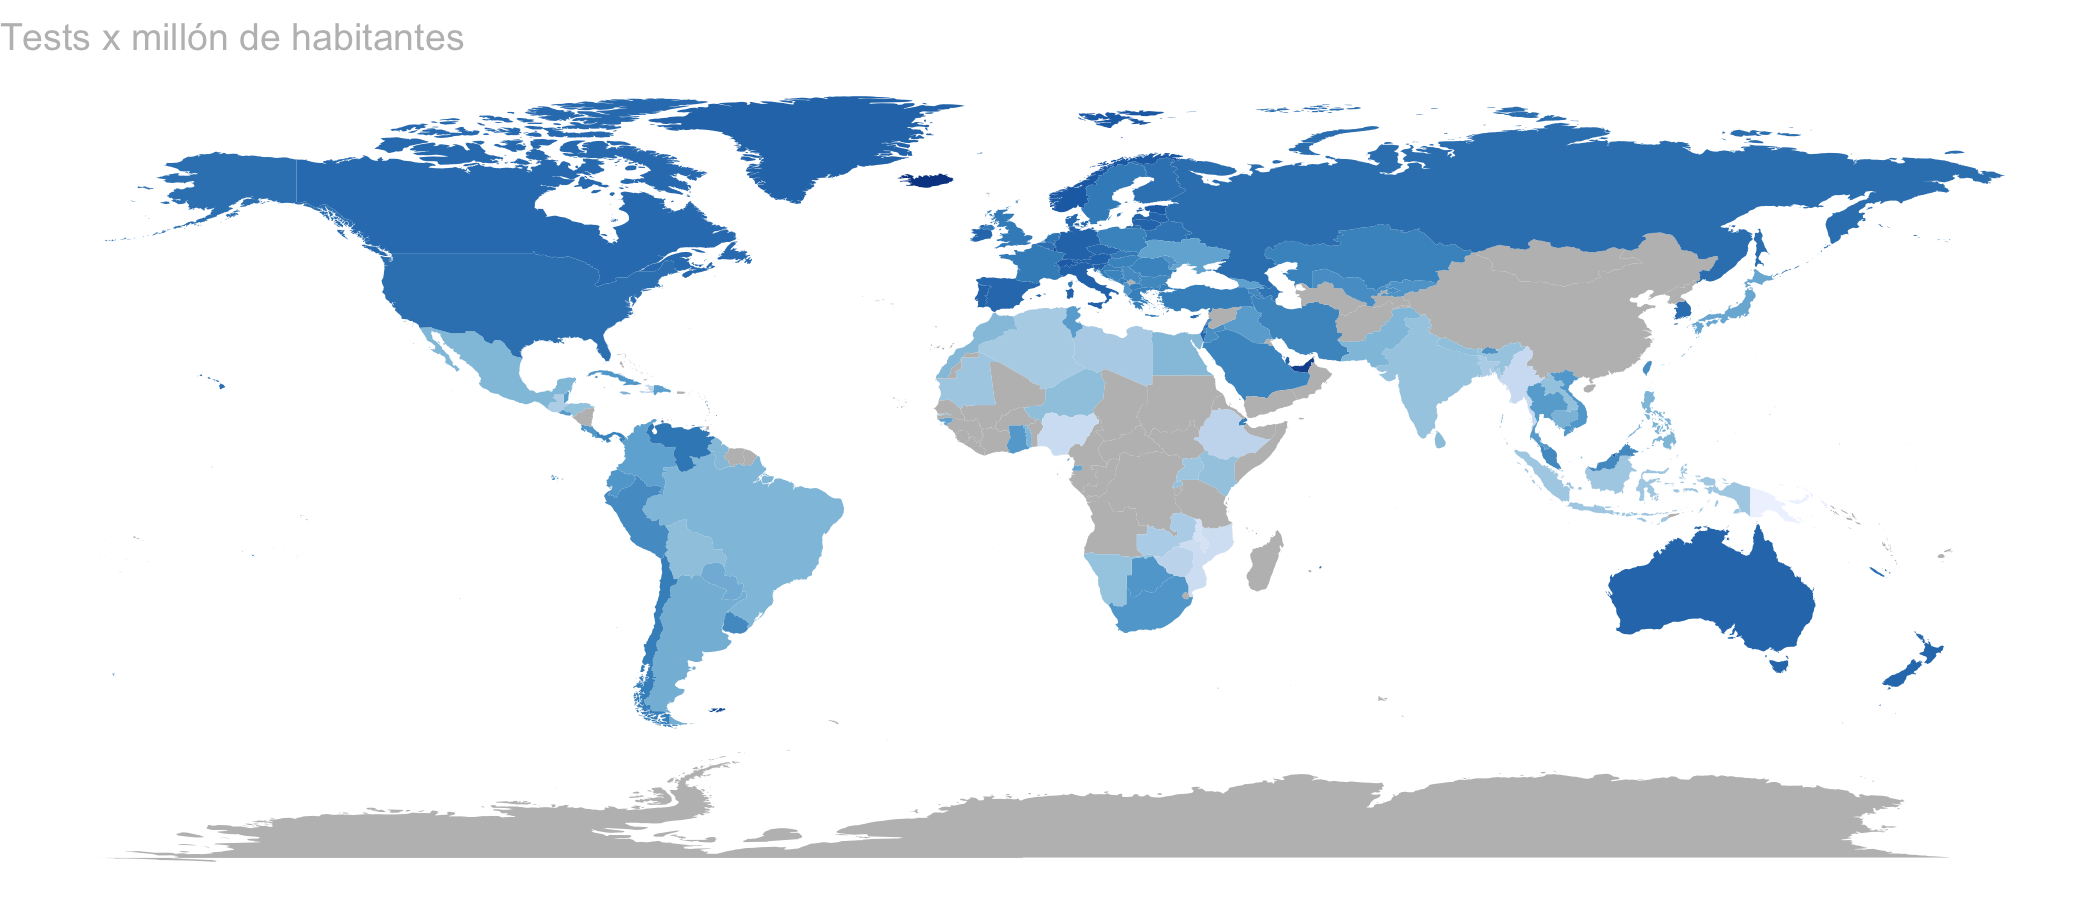

In [60]:
data %>%
    select(region = Country, x=Tests.1M) %>%
    world.map(theme = theme1, title = "Tests x millón de habitantes", func = function(x){-log10(x)})

Selecting by Tests.1M



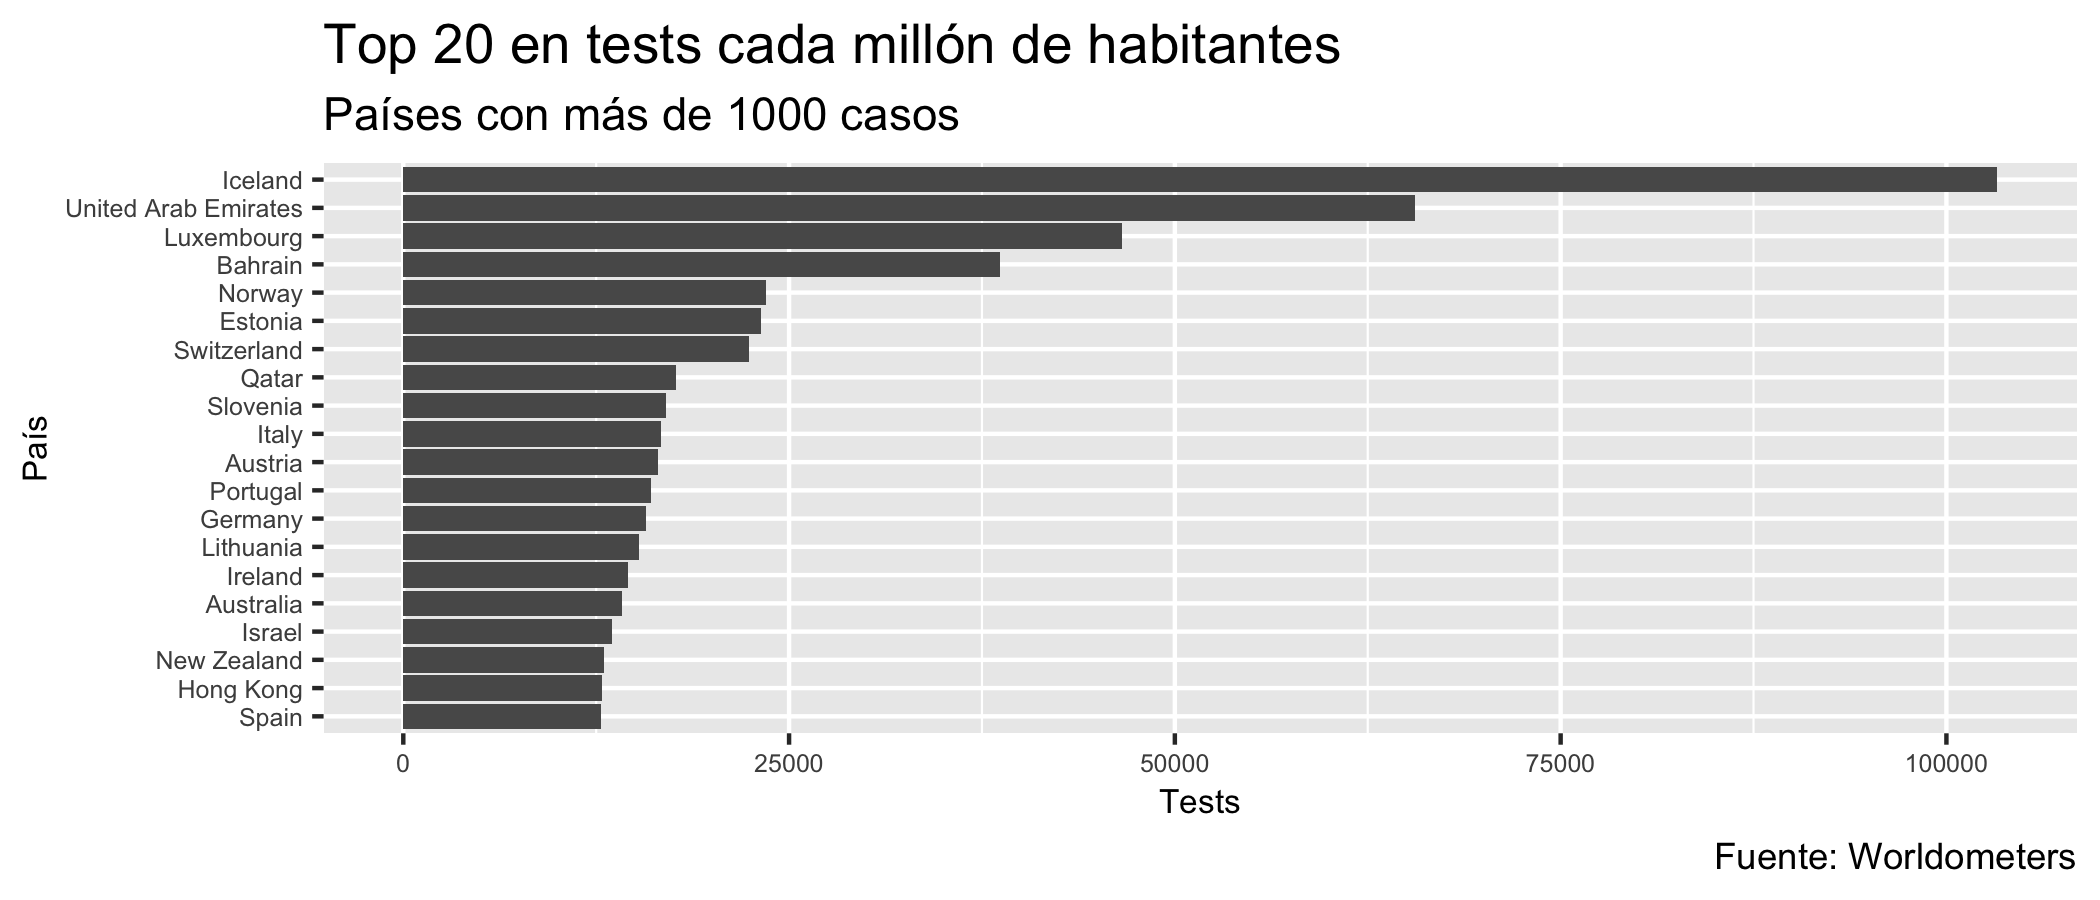

In [61]:
data %>%
    filter(TotalCases >= 1000) %>%
    arrange(desc(Tests.1M)) %>%
    select(Country, Tests.1M) %>%
    top_n(20) %>%
    ggplot(aes(x=reorder(Country,Tests.1M),y=Tests.1M)) + 
    geom_bar(stat = 'identity') +
    ylab("Tests") +
    xlab("País") +
    labs(
        title = "Top 20 en tests cada millón de habitantes",
        subtitle = "Países con más de 1000 casos",
        caption="Fuente: Worldometers")+
    theme(axis.text.y = element_text( hjust = 1, size = 6),
          axis.text.x = element_text( size = 6),
          axis.title.y = element_text(size = 8),
          axis.title.x = element_text(size = 8)
         ) + 
    coord_flip()


## Indicadores

La tasa de letalidad y el % de positivos (Casos/Testeos) parecen tener una correlación directa

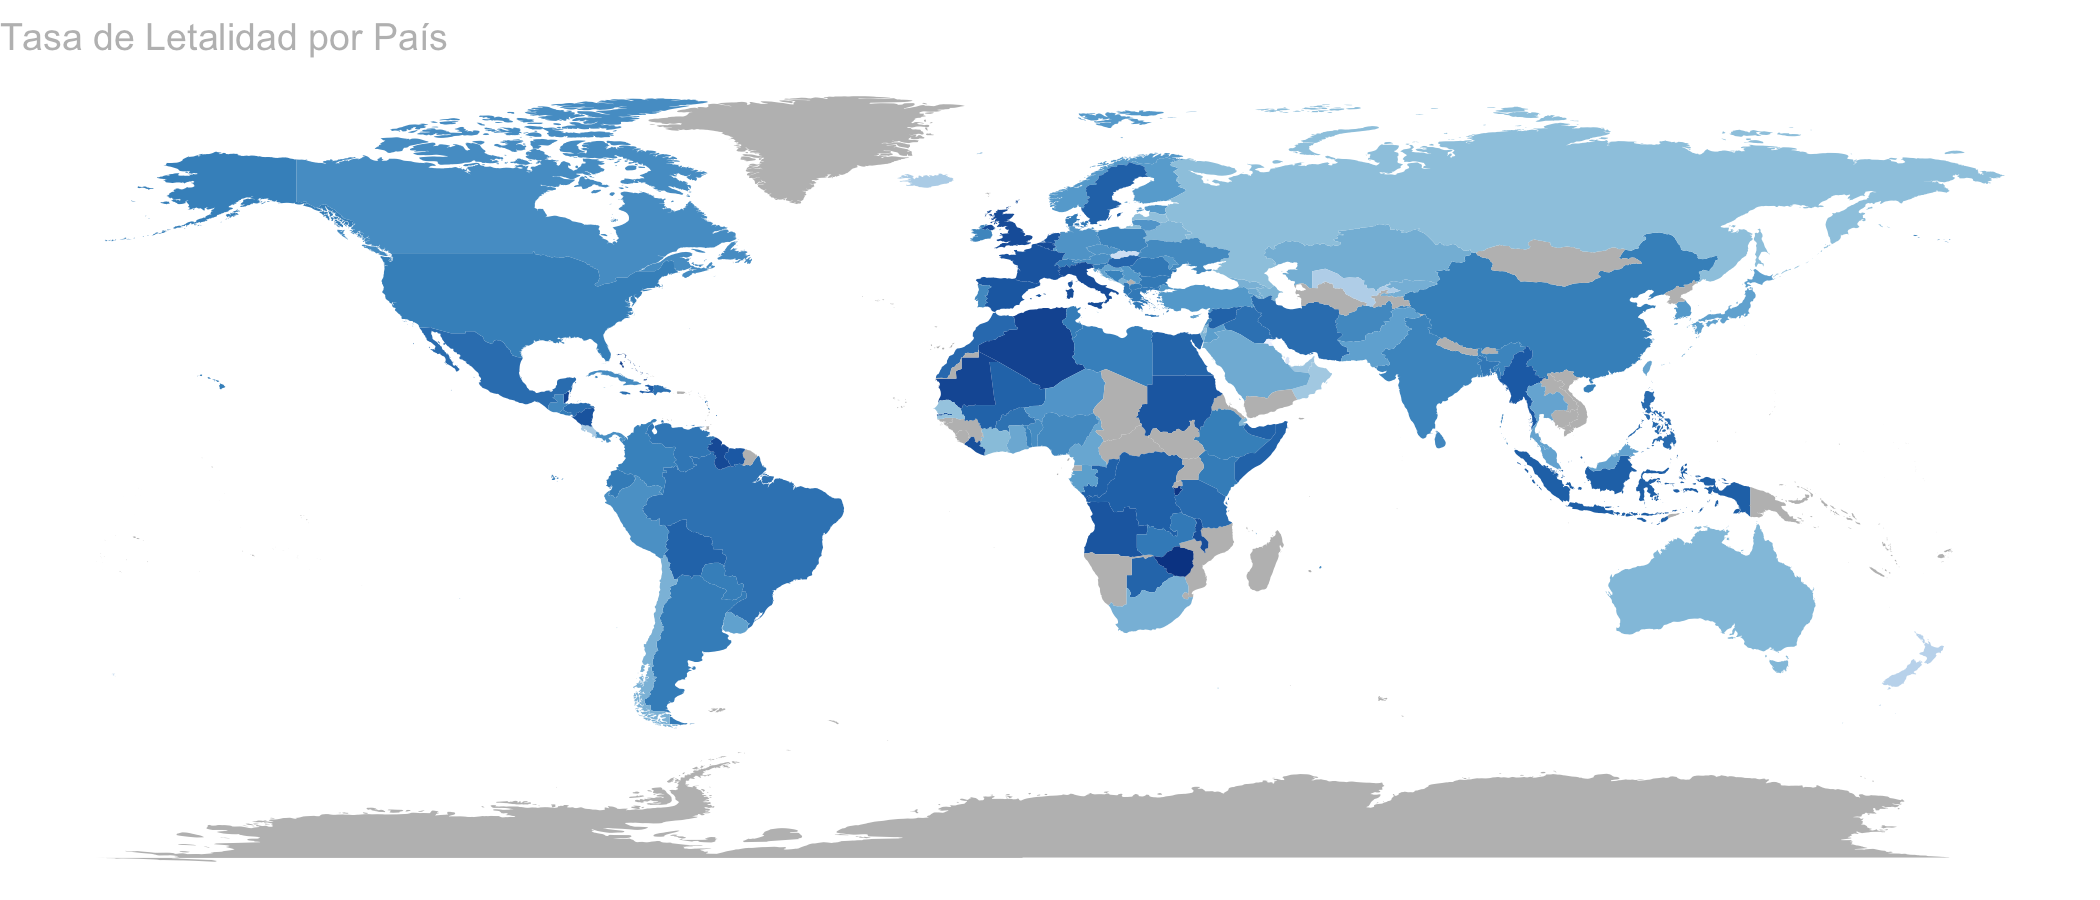

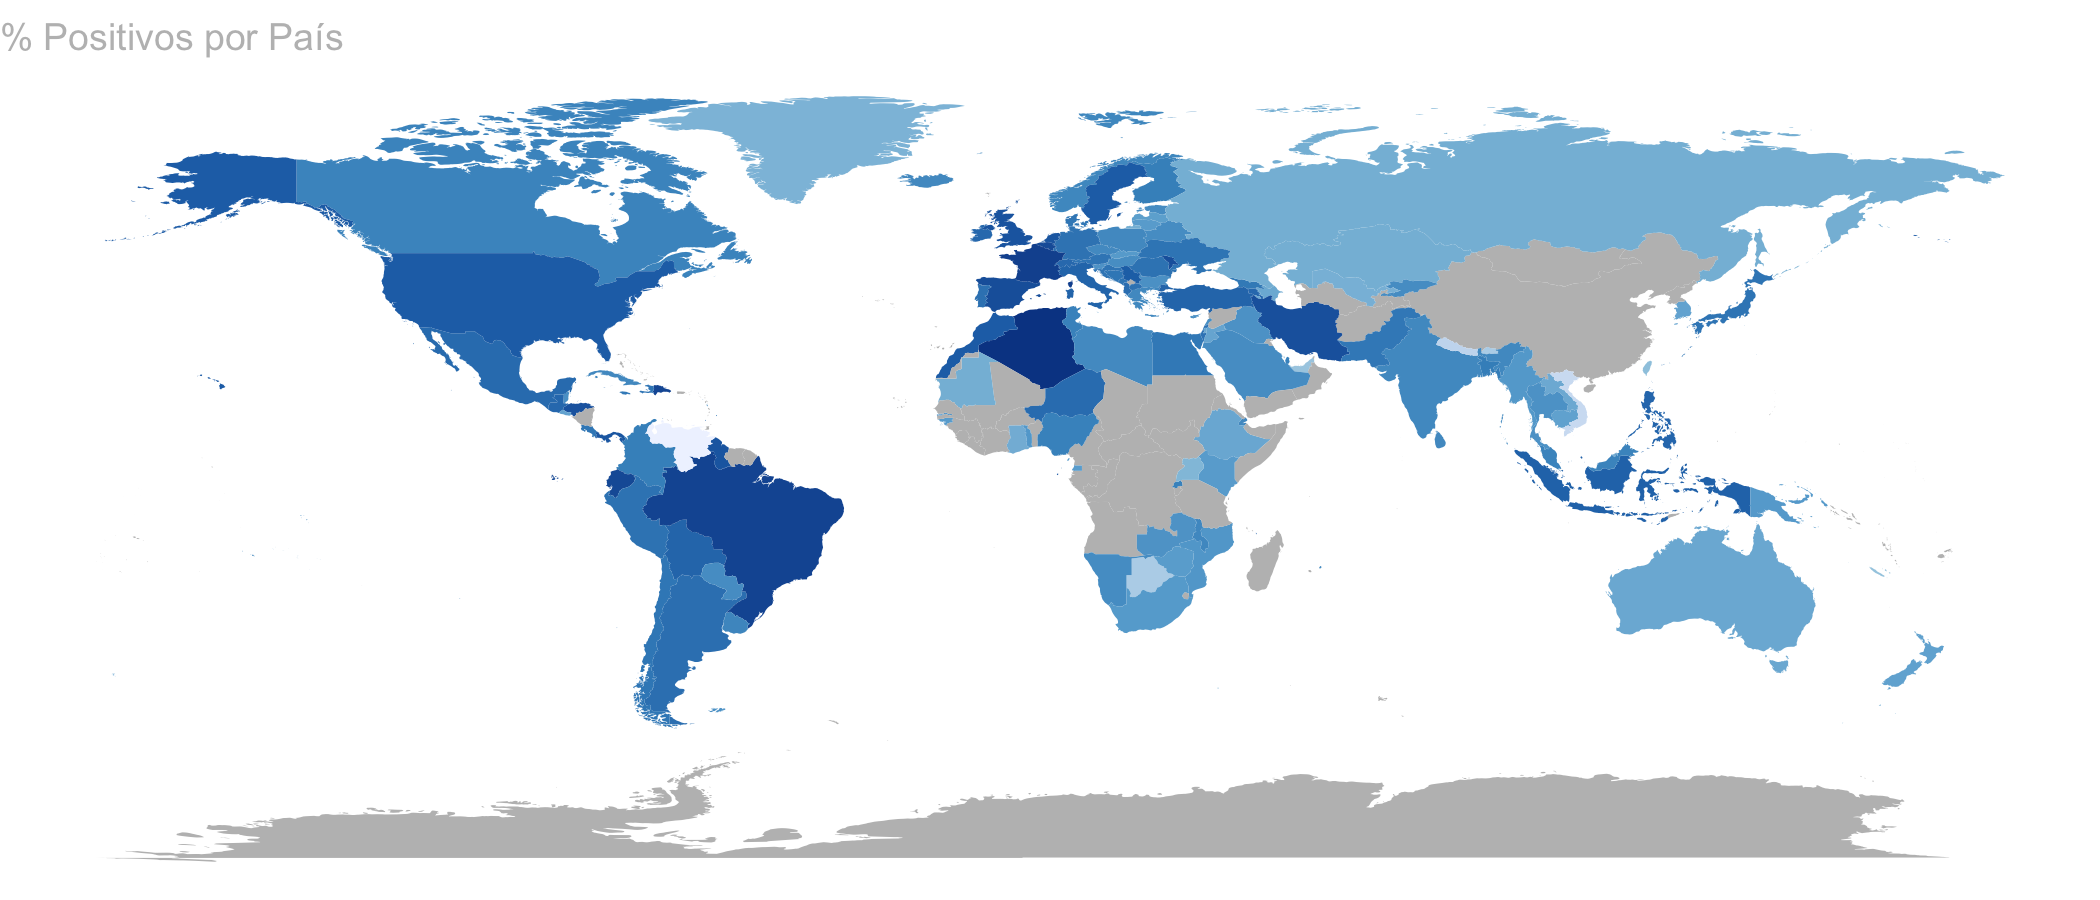

In [62]:
data %>%
    select(region = Country, x=fatality.rate) %>%
    world.map(theme = theme1, title = "Tasa de Letalidad por País", func = function(x){-log10(x)})

data %>%
    select(region = Country, x=positive.rate) %>%
    world.map(theme = theme1, title = "% Positivos por País",func = function(x){-log10(x)})

El gráfico siguiente muestra la relación entre el % de positivos y la tasa de letalidad de cada país. El tamaño de cada punto corresponde a los tests x millón de habitantes

Warning message:
“Removed 79 rows containing missing values (geom_point).”


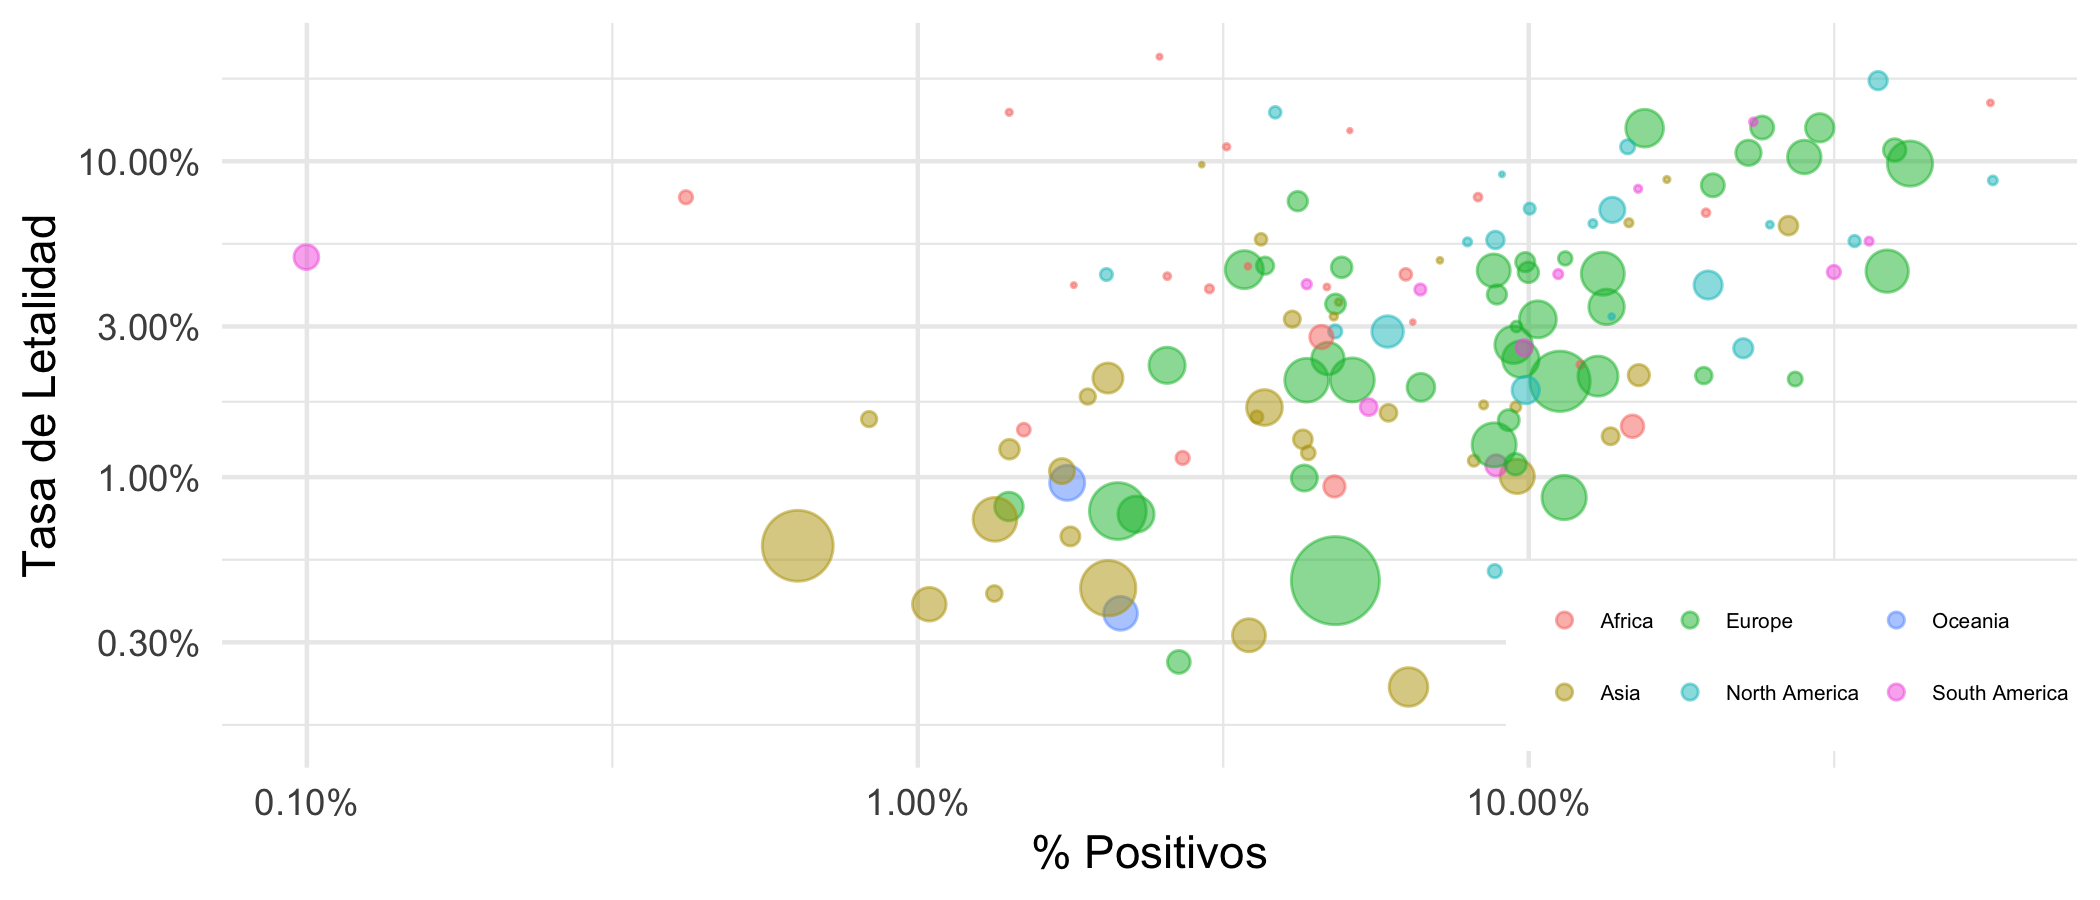

In [63]:
data %>%
#    filter(TotalCases >= 1000) %>%
    ggplot(aes(x=positive.rate, y=fatality.rate, size = Tests.1M, colour = Continent)) +
    geom_point(alpha=0.5) +
    xlab("% Positivos") + ylab("Tasa de Letalidad") +
    scale_size(range = c(.1, 10), name="Test x Millón", guide = 'none') +
    scale_y_continuous(trans='log10', labels = scales::percent) +
    scale_x_continuous(trans='log10', labels = scales::percent) +
    theme_minimal() + 
    theme(legend.title = element_text(size = 0), 
          legend.text=element_text(size = 5), 
          legend.direction = 'horizontal',
          legend.position = c(0.85, 0.15),
          legend.background = element_rect(fill = "white", color = NA),
         )

Y finalmente, el % de pacientes críticos, en relación a los casos activos

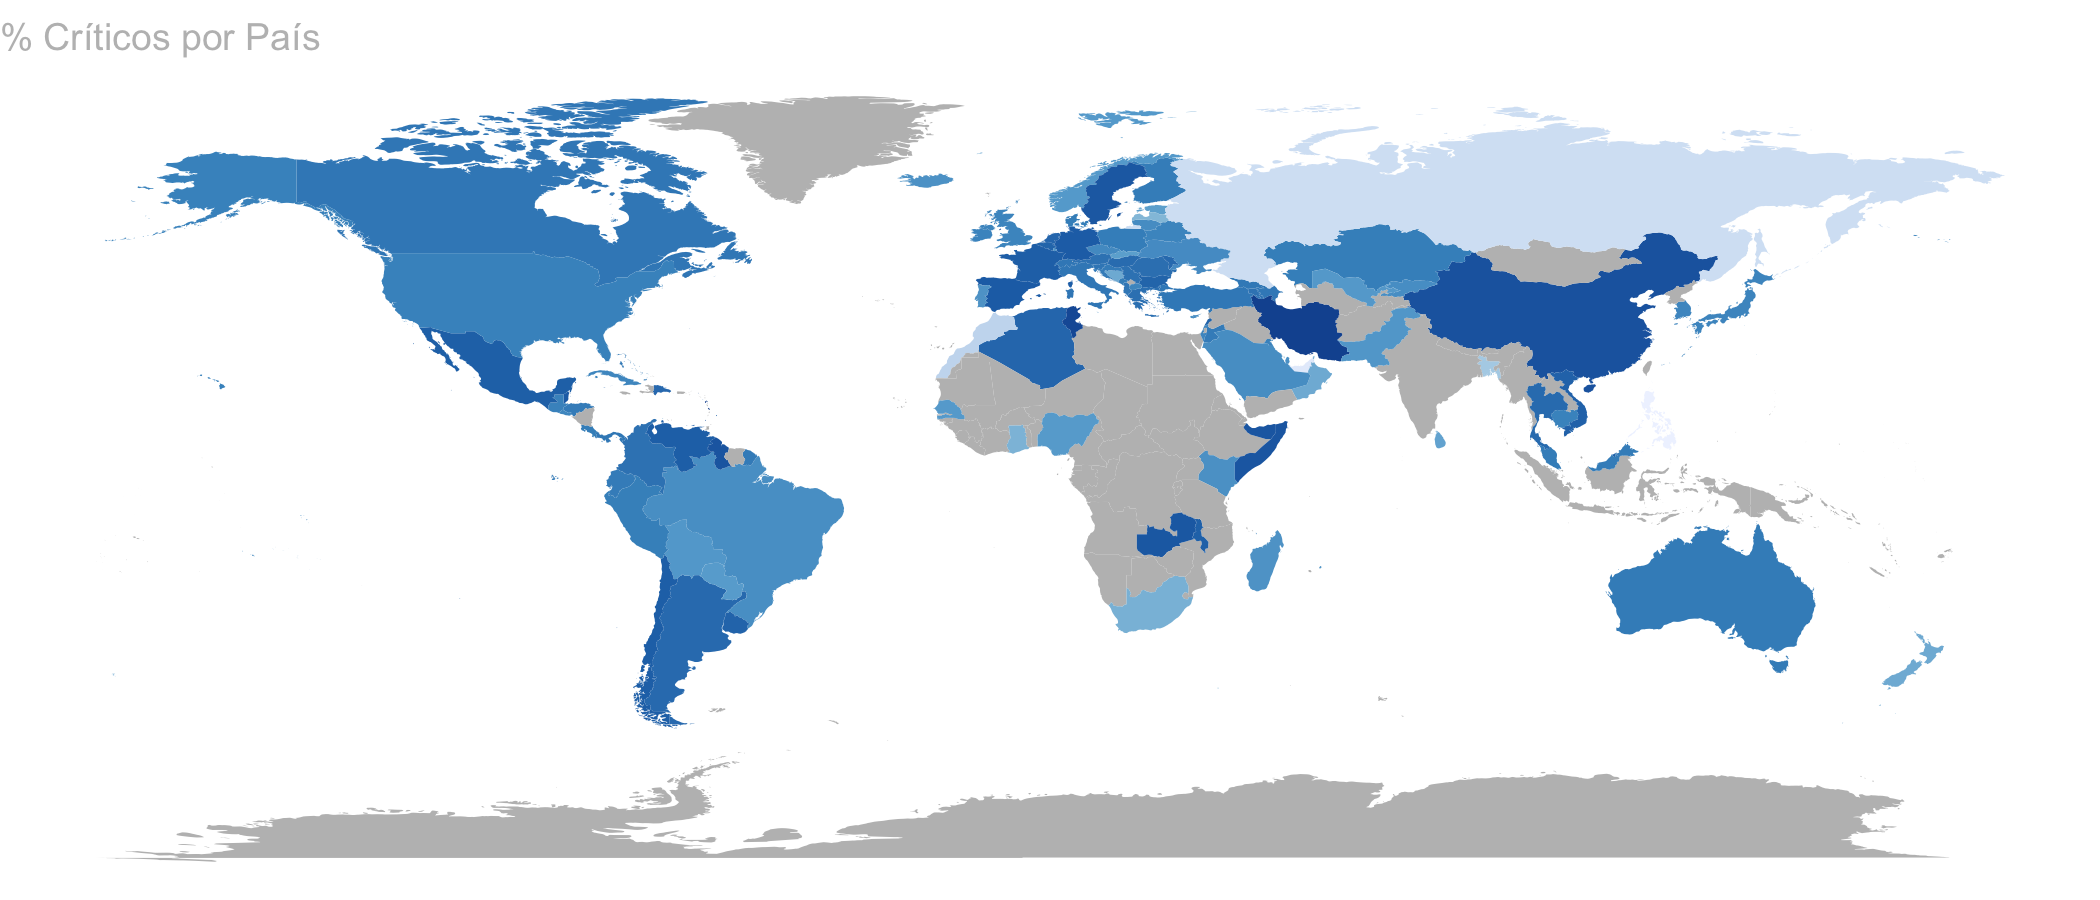

In [64]:
data %>%
    select(region = Country, x=critical.rate) %>%
    world.map(theme = theme1, title = "% Críticos por País", func = function(x){-log10(x)})